# A. Data Preparation

In [1]:
# Importing useful libraries

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from IPython.display import display

In [2]:
# Loading data as dataframes

df_assessments = pd.read_csv("assessments.csv")
df_stdnt_assessment = pd.read_csv("studentAssessment.csv")
df_stdnt_vle = pd.read_csv("studentVle.csv")
df_vle = pd.read_csv("vle.csv")
df_stdnt_info = pd.read_csv("studentInfo.csv")
df_stdnt_registration = pd.read_csv("studentRegistration.csv")

In [3]:
# Processing studentAssessment data

df_stdnt_assessment = pd.merge(df_stdnt_assessment, df_assessments, on="id_assessment", how="left")
df_stdnt_assessment["weighted_score"] = df_stdnt_assessment["score"] * df_stdnt_assessment["weight"] / 100
df_stdnt_assessment = df_stdnt_assessment.pivot_table(index=["id_student", "code_module", "code_presentation"], columns="assessment_type", values="weighted_score", aggfunc="sum", fill_value=0)
df_stdnt_assessment = df_stdnt_assessment.reset_index()[["id_student", "code_module", "code_presentation", "TMA"]]

In [4]:
df_stdnt_assessment

assessment_type,id_student,code_module,code_presentation,TMA
0,6516,AAA,2014J,63.50
1,8462,DDD,2013J,34.90
2,8462,DDD,2014J,43.00
3,11391,AAA,2013J,82.40
4,23629,BBB,2013B,14.69
...,...,...,...,...
25838,2698257,AAA,2013J,69.40
25839,2698535,CCC,2014B,5.06
25840,2698535,EEE,2013J,53.44
25841,2698577,BBB,2014J,55.80


In [5]:
# Processing studentVle data, creating student interactions data for the resources available at each module

df_stdnt_vle = df_stdnt_vle.groupby(["id_student", "id_site"]).agg({"sum_click": sum}).reset_index()
df_interactions = pd.merge(df_stdnt_vle, df_vle, on="id_site", how="left")
df_interactions = df_interactions.pivot_table(index=["id_student", "code_module", "code_presentation"], columns="activity_type", values="sum_click", aggfunc="sum", fill_value=0)
df_interactions = df_interactions.reset_index()

In [6]:
df_interactions

activity_type,id_student,code_module,code_presentation,dataplus,dualpane,externalquiz,folder,forumng,glossary,homepage,...,ouelluminate,ouwiki,page,questionnaire,quiz,repeatactivity,resource,sharedsubpage,subpage,url
0,6516,AAA,2014J,21,0,0,0,451,0,497,...,0,0,0,0,0,0,31,0,143,143
1,8462,DDD,2013J,0,0,12,0,36,0,184,...,0,18,0,0,0,0,70,0,227,23
2,8462,DDD,2014J,0,0,0,0,2,0,7,...,0,0,0,0,0,0,0,0,0,0
3,11391,AAA,2013J,0,0,0,0,193,0,138,...,0,0,0,0,0,0,13,0,32,5
4,23629,BBB,2013B,0,0,0,0,87,0,36,...,0,0,0,0,31,0,2,0,5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29223,2698257,AAA,2013J,0,0,0,0,201,0,165,...,0,0,0,0,0,0,12,0,44,5
29224,2698535,CCC,2014B,0,0,0,0,309,0,98,...,0,0,0,0,292,0,23,0,52,6
29225,2698535,EEE,2013J,0,2,0,0,1953,0,391,...,0,119,0,0,111,0,3,0,13,90
29226,2698577,BBB,2014J,0,0,0,0,103,0,204,...,0,0,0,0,72,0,38,0,38,4


In [7]:
# Filtering interactions with high variance in number of clicks

for col in df_interactions.columns:
    if df_interactions[col].dtype == "int64":
        if df_interactions[col].value_counts().std() >= 500:
            df_interactions.drop(labels=col, axis=1, inplace=True)

In [8]:
df_interactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29228 entries, 0 to 29227
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id_student         29228 non-null  int64 
 1   code_module        29228 non-null  object
 2   code_presentation  29228 non-null  object
 3   forumng            29228 non-null  int64 
 4   homepage           29228 non-null  int64 
 5   oucontent          29228 non-null  int64 
 6   quiz               29228 non-null  int64 
 7   resource           29228 non-null  int64 
 8   subpage            29228 non-null  int64 
 9   url                29228 non-null  int64 
dtypes: int64(8), object(2)
memory usage: 2.2+ MB


In [9]:
# Merging studentInfo with interactions, scores and registration

df_model = pd.merge(df_stdnt_info, df_stdnt_assessment, on=["code_module", "code_presentation", "id_student"], how="left")
df_model = pd.merge(df_model, df_interactions, on=["code_module", "code_presentation", "id_student"], how="left")
df_model = pd.merge(df_model, df_stdnt_registration, on=["code_module", "code_presentation", "id_student"], how="left")

In [10]:
df_model

,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,...,TMA,forumng,homepage,oucontent,quiz,resource,subpage,url,date_registration,date_unregistration
0,AAA,2013J,11391,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,...,82.400000,193.0,138.0,553.0,0.0,13.0,32.0,5.0,-159.0,NaN
1,AAA,2013J,28400,F,Scotland,HE Qualification,20-30%,35-55,0,60,...,65.400000,417.0,324.0,537.0,0.0,12.0,87.0,48.0,-53.0,NaN
2,AAA,2013J,30268,F,North Western Region,A Level or Equivalent,30-40%,35-55,0,60,...,NaN,126.0,59.0,66.0,0.0,4.0,22.0,4.0,-92.0,12.0
3,AAA,2013J,31604,F,South East Region,A Level or Equivalent,50-60%,35-55,0,60,...,76.300000,634.0,432.0,836.0,0.0,19.0,144.0,90.0,-52.0,NaN
4,AAA,2013J,32885,F,West Midlands Region,Lower Than A Level,50-60%,0-35,0,60,...,55.000000,194.0,204.0,494.0,0.0,45.0,79.0,14.0,-176.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32588,GGG,2014J,2640965,F,Wales,Lower Than A Level,10-20,0-35,0,30,...,NaN,0.0,22.0,6.0,0.0,4.0,9.0,0.0,-4.0,NaN
32589,GGG,2014J,2645731,F,East Anglian Region,Lower Than A Level,40-50%,35-55,0,30,...,77.666667,65.0,167.0,348.0,152.0,109.0,47.0,0.0,-23.0,NaN
32590,GGG,2014J,2648187,F,South Region,A Level or Equivalent,20-30%,0-35,0,30,...,70.000000,0.0,63.0,79.0,130.0,19.0,20.0,0.0,-129.0,NaN
32591,GGG,2014J,2679821,F,South East Region,Lower Than A Level,90-100%,35-55,0,30,...,27.666667,118.0,65.0,40.0,31.0,9.0,12.0,0.0,-49.0,101.0


## B. Analyzing Categorical Features

In [11]:
# Unique values for each of the non-numeric features:

for col in df_model.iloc[:, 3:].columns:
    if df_model[col].dtype == 'object':
        print(f"{col} has {len(df_model[col].unique())} unique values:")
        print(df_model[col].value_counts(), "\n")

gender has 2 unique values:
M    17875
F    14718
Name: gender, dtype: int64 

region has 13 unique values:
Scotland                3446
East Anglian Region     3340
London Region           3216
South Region            3092
North Western Region    2906
West Midlands Region    2582
South West Region       2436
East Midlands Region    2365
South East Region       2111
Wales                   2086
Yorkshire Region        2006
North Region            1823
Ireland                 1184
Name: region, dtype: int64 

highest_education has 5 unique values:
A Level or Equivalent          14045
Lower Than A Level             13158
HE Qualification                4730
No Formal quals                  347
Post Graduate Qualification      313
Name: highest_education, dtype: int64 

imd_band has 11 unique values:
20-30%     3654
30-40%     3539
10-20      3516
0-10%      3311
40-50%     3256
50-60%     3124
60-70%     2905
70-80%     2879
80-90%     2762
90-100%    2536
Name: imd_band, dtype: int64 



In [12]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32593 entries, 0 to 32592
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   code_module           32593 non-null  object 
 1   code_presentation     32593 non-null  object 
 2   id_student            32593 non-null  int64  
 3   gender                32593 non-null  object 
 4   region                32593 non-null  object 
 5   highest_education     32593 non-null  object 
 6   imd_band              31482 non-null  object 
 7   age_band              32593 non-null  object 
 8   num_of_prev_attempts  32593 non-null  int64  
 9   studied_credits       32593 non-null  int64  
 10  disability            32593 non-null  object 
 11  final_result          32593 non-null  object 
 12  TMA                   25843 non-null  float64
 13  forumng               29228 non-null  float64
 14  homepage              29228 non-null  float64
 15  oucontent          

## C. Categorization, Cleaning and Feature Encoding

In [13]:
df_train = df_model.iloc[:, 3:]
df_train.rename(columns=lambda x: x.lower(), inplace=True)

df_train["imd_band"] = df_train["imd_band"].str.replace(r'%', '')
df_train["imd_band"].fillna("20-30", inplace=True)

df_train.fillna(value=0, inplace=True)

for col in df_train.columns:
    if df_train[col].dtype == "float64":
        df_train[col] = df_train[col].astype(int)
    else:
        df_train[col] = df_train[col].astype(str)

In [14]:
df_train

,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result,tma,forumng,homepage,oucontent,quiz,resource,subpage,url,date_registration,date_unregistration
0,M,East Anglian Region,HE Qualification,90-100,55<=,0,240,N,Pass,82,193,138,553,0,13,32,5,-159,0
1,F,Scotland,HE Qualification,20-30,35-55,0,60,N,Pass,65,417,324,537,0,12,87,48,-53,0
2,F,North Western Region,A Level or Equivalent,30-40,35-55,0,60,Y,Withdrawn,0,126,59,66,0,4,22,4,-92,12
3,F,South East Region,A Level or Equivalent,50-60,35-55,0,60,N,Pass,76,634,432,836,0,19,144,90,-52,0
4,F,West Midlands Region,Lower Than A Level,50-60,0-35,0,60,N,Pass,55,194,204,494,0,45,79,14,-176,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32588,F,Wales,Lower Than A Level,10-20,0-35,0,30,N,Fail,0,0,22,6,0,4,9,0,-4,0
32589,F,East Anglian Region,Lower Than A Level,40-50,35-55,0,30,N,Distinction,77,65,167,348,152,109,47,0,-23,0
32590,F,South Region,A Level or Equivalent,20-30,0-35,0,30,Y,Pass,69,0,63,79,130,19,20,0,-129,0
32591,F,South East Region,Lower Than A Level,90-100,35-55,0,30,N,Withdrawn,27,118,65,40,31,9,12,0,-49,101


## Features Description

1. **Gender**: Male or Female (Category).
2. **Region**: Part of England where the student comes from.
3. **Highest Education**: Student highest level of education achieved.
4. **Multiple Deprivation Index - Band**: Indicator of necesity per location zones in England.
5. **Age - Band**: Student age range.
6. **Number of Previous Attempts**: Previous attempst to complete de course.
7. **Studied Credits**: Total number of credits enrolled by the student.
8. **Disability**: Student with disabiliy.
9. **TMA Score**: Weighted average of the Tutor Marked Assignment scores.
10. **Number of Clicks per Study Resource**: Sum of clicks per student per resource.
 - forumng
 - homepage
 - oucontent
 - quiz
 - resource
 - subpage
 - url
11. **Registration/Unregistration Dates**: Date wheter the student registered or unregistered into the course.


In [15]:
from sklearn import preprocessing
from sklearn.feature_selection import SelectKBest, chi2

# education = pd.get_dummies(df_train["highest_education"])
# imd_band = pd.get_dummies(df_train["imd_band"])
# age_band = pd.get_dummies(df_train["age_band"])

label_encoder = preprocessing.LabelEncoder()
df_train["highest_education"] = label_encoder.fit_transform(df_train["highest_education"])
df_train["gender"] = label_encoder.fit_transform(df_train["gender"])
df_train["disability"] = label_encoder.fit_transform(df_train["disability"])
df_train["imd_band"] = label_encoder.fit_transform(df_train["imd_band"])
df_train["age_band"] = label_encoder.fit_transform(df_train["age_band"])
df_train["region"] = label_encoder.fit_transform(df_train["region"])

df_train["date_registration"] = df_train["date_registration"].abs()

unregistered_classifier = lambda x: 1 if x != 0 else 0
result_classifier = lambda x: 1 if x == 'Pass' or x == 'Distinction' else 0
df_train["date_unregistration"] = df_train["date_unregistration"].apply(unregistered_classifier)
df_train["final_result"] = df_train["final_result"].apply(result_classifier)

for col in df_train.columns:
    df_train[col].astype(int)

## Features Importance

                 Feature         Score
0              oucontent  5.494844e+06
1                forumng  3.793120e+06
2                   quiz  3.080685e+06
3               homepage  2.812271e+06
4                subpage  1.098650e+06
5               resource  3.072194e+05
6                    url  2.060707e+05
7        studied_credits  1.324764e+04
8      date_registration  3.388133e+03
9               imd_band  8.465651e+02
10  num_of_prev_attempts  5.111415e+02
11     highest_education  3.590227e+02


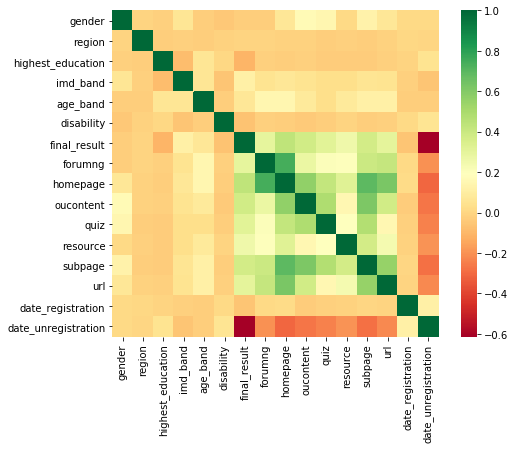

In [16]:
to_drop = ["tma", "date_unregistration", "final_result"]

X = df_train.drop(to_drop, axis=1)
y = df_train["final_result"]

best_features = SelectKBest(score_func=chi2, k=12)
fit = best_features.fit(X, y)
df_scores = pd.DataFrame(fit.scores_)
df_columns = pd.DataFrame(X.columns)

# Concat two dataframes for better visualization 
feature_scores = pd.concat([df_columns, df_scores], axis=1)
feature_scores.columns = ['Feature','Score']

# Comparing methods: SelectKBest and Heatmap Correlation Matrix
print(feature_scores.nlargest(12,'Score').reset_index(drop=True))
plt.figure(figsize=[8, 6])
sns.heatmap(df_train.drop(to_drop[:1], axis=1).corr(), square=True, cmap='RdYlGn')

# D. Training Different Models

In [17]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score

# Metrics summary for further evaluation
df_metrics = pd.DataFrame(
    index=["Accuracy", "Precision", "Recall"],
    columns=["Logistic Regression", "Decision Tree", "Nearest Neighbors", "Gradient Descent", "Support Vector Machine"]
)

# Defining features and target:
X = X.values
y = y.values

# Extracting data for training and testing:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)
scaler = preprocessing.StandardScaler()
X_scaled = scaler.fit_transform(X_train)

### 1. Logistic Regression

In [18]:
from sklearn.linear_model import LogisticRegression

lg_clf = LogisticRegression(max_iter=5000, C=0.4)
lg_clf.fit(X_train, y_train)
y_pred = lg_clf.predict(X_test)

# Metrics
cr_lg = pd.DataFrame(classification_report(y_test, y_pred, output_dict=True))
display(cr_lg)

df_metrics.loc["Accuracy", "Logistic Regression"] = cr_lg.loc["precision", "accuracy"]
df_metrics.loc["Precision", "Logistic Regression"] = cr_lg.loc["precision", "macro avg"]
df_metrics.loc["Recall", "Logistic Regression"] = cr_lg.loc["recall", "macro avg"]

# Confusion Matrix for Logistic Regression
cm_lg = confusion_matrix(y_test, y_pred)
df_cm_lg = pd.DataFrame(cm_lg, index=["Actual Fail", "Actual Pass"], columns=["Pred Fail", "Pred Pass"])
df_cm_lg

,0,1,accuracy,macro avg,weighted avg
precision,0.780458,0.822108,0.797914,0.801283,0.800120
recall,0.858776,0.729853,0.797914,0.794314,0.797914
f1-score,0.817746,0.773238,0.797914,0.795492,0.796735
support,5162.000000,4616.000000,0.797914,9778.000000,9778.000000


,Pred Fail,Pred Pass
Actual Fail,4433,729
Actual Pass,1247,3369


### 2. Decision Tree

In [19]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

dt_clf = DecisionTreeClassifier()
dt_clf.fit(X_train, y_train)

y_pred = dt_clf.predict(X_test)

# Metrics
cr_dt = pd.DataFrame(classification_report(y_test, y_pred, output_dict=True))
display(cr_dt)

df_metrics.loc["Accuracy", "Decision Tree"] = cr_dt.loc["precision", "accuracy"]
df_metrics.loc["Precision", "Decision Tree"] = cr_dt.loc["precision", "macro avg"]
df_metrics.loc["Recall", "Decision Tree"] = cr_dt.loc["recall", "macro avg"]

# Confusion Matrix for Logistic Regression
cm_dt = confusion_matrix(y_test, y_pred)
df_cm_dt = pd.DataFrame(cm_dt, index=["Actual Fail", "Actual Pass"], columns=["Pred Fail", "Pred Pass"])
df_cm_dt

,0,1,accuracy,macro avg,weighted avg
precision,0.801525,0.772084,0.787482,0.786805,0.787627
recall,0.794072,0.780113,0.787482,0.787092,0.787482
f1-score,0.797781,0.776078,0.787482,0.786929,0.787535
support,5162.000000,4616.000000,0.787482,9778.000000,9778.000000


,Pred Fail,Pred Pass
Actual Fail,4099,1063
Actual Pass,1015,3601


### 3. Nearest Neighbors

In [20]:
from sklearn.neighbors import KNeighborsClassifier

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_train)

y_pred = knn_clf.predict(X_test)

# Metrics
cr_nn = pd.DataFrame(classification_report(y_test, y_pred, output_dict=True))
display(cr_nn)

df_metrics.loc["Accuracy", "Nearest Neighbors"] = cr_nn.loc["precision", "accuracy"]
df_metrics.loc["Precision", "Nearest Neighbors"] = cr_nn.loc["precision", "macro avg"]
df_metrics.loc["Recall", "Nearest Neighbors"] = cr_nn.loc["recall", "macro avg"]

# Confusion Matrix for Logistic Regression
cm_nn = confusion_matrix(y_test, y_pred)
df_cm_nn = pd.DataFrame(cm_nn, index=["Actual Fail", "Actual Pass"], columns=["Pred Fail", "Pred Pass"])
df_cm_nn

,0,1,accuracy,macro avg,weighted avg
precision,0.851354,0.788707,0.819697,0.820030,0.821780
recall,0.797753,0.844237,0.819697,0.820995,0.819697
f1-score,0.823682,0.815528,0.819697,0.819605,0.819833
support,5162.000000,4616.000000,0.819697,9778.000000,9778.000000


,Pred Fail,Pred Pass
Actual Fail,4118,1044
Actual Pass,719,3897


### 4. Gradient Descent

In [21]:
from sklearn.linear_model import SGDClassifier

gd_clf = SGDClassifier()
gd_clf.fit(X_scaled, y_train)

y_pred = gd_clf.predict(X_test)

# Metrics
cr_gd = pd.DataFrame(classification_report(y_test, y_pred, output_dict=True))
display(cr_gd)

df_metrics.loc["Accuracy", "Gradient Descent"] = cr_gd.loc["precision", "accuracy"]
df_metrics.loc["Precision", "Gradient Descent"] = cr_gd.loc["precision", "macro avg"]
df_metrics.loc["Recall", "Gradient Descent"] = cr_gd.loc["recall", "macro avg"]

# Confusion Matrix for Logistic Regression
cm_gd = confusion_matrix(y_test, y_pred)
df_cm_gd = pd.DataFrame(cm_gd, index=["Actual Fail", "Actual Pass"], columns=["Pred Fail", "Pred Pass"])
df_cm_gd

,0,1,accuracy,macro avg,weighted avg
precision,0.998017,0.558137,0.626202,0.778077,0.790358
recall,0.292522,0.999350,0.626202,0.645936,0.626202
f1-score,0.452434,0.716249,0.626202,0.584342,0.576976
support,5162.000000,4616.000000,0.626202,9778.000000,9778.000000


,Pred Fail,Pred Pass
Actual Fail,1510,3652
Actual Pass,3,4613


### 5. Support Vector Machine

In [22]:
from sklearn.svm import SVC

sv_clf = SGDClassifier()
sv_clf.fit(X_scaled, y_train)

y_pred = sv_clf.predict(X_test)

# Metrics
cr_sv = pd.DataFrame(classification_report(y_test, y_pred, output_dict=True))
display(cr_sv)

df_metrics.loc["Accuracy", "Support Vector Machine"] = cr_sv.loc["precision", "accuracy"]
df_metrics.loc["Precision", "Support Vector Machine"] = cr_sv.loc["precision", "macro avg"]
df_metrics.loc["Recall", "Support Vector Machine"] = cr_sv.loc["recall", "macro avg"]

# Confusion Matrix for Logistic Regression
cm_sv = confusion_matrix(y_test, y_pred)
df_cm_sv = pd.DataFrame(cm_sv, index=["Actual Fail", "Actual Pass"], columns=["Pred Fail", "Pred Pass"])
df_cm_sv

,0,1,accuracy,macro avg,weighted avg
precision,0.998043,0.559491,0.628247,0.778767,0.791011
recall,0.296397,0.999350,0.628247,0.647873,0.628247
f1-score,0.457058,0.717363,0.628247,0.587210,0.579942
support,5162.000000,4616.000000,0.628247,9778.000000,9778.000000


,Pred Fail,Pred Pass
Actual Fail,1530,3632
Actual Pass,3,4613


# E. Performance of the Models

Performance measurements:
- **Accuracy**: Number of **true predictions** over the **total of predictions**.
- **Precision**: Number of predicted **true pass** over the total predictions of **pass**.
- **Recall**: Number of predicted **true pass** over the total actual of **pass**.

In [23]:
df_metrics

,Logistic Regression,Decision Tree,Nearest Neighbors,Gradient Descent,Support Vector Machine
Accuracy,0.797914,0.787482,0.819697,0.626202,0.628247
Precision,0.801283,0.786805,0.82003,0.778077,0.778767
Recall,0.794314,0.787092,0.820995,0.645936,0.647873


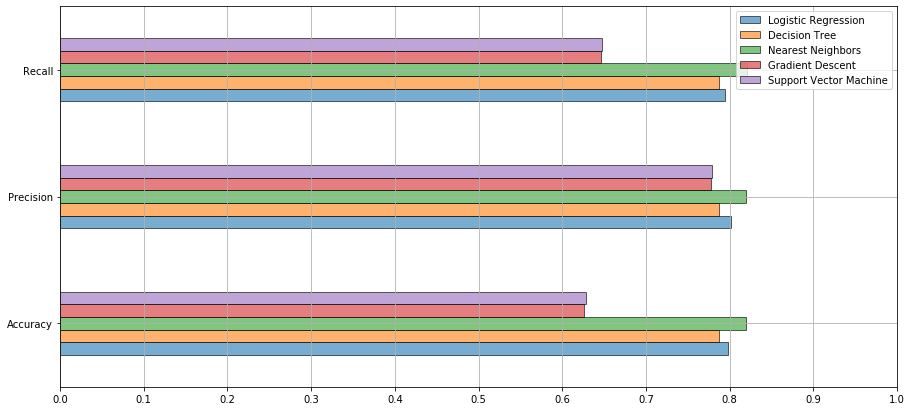

In [24]:
x_ticks = np.linspace(0, 1, 11)
fig, ax = plt.subplots(figsize=[15, 7])
df_metrics.plot(kind="barh", ax=ax, ec="black", alpha=0.6)
ax.set_xticks(x_ticks)
ax.legend()
ax.grid()

## Nearest Neighbor performance evaluation

In [25]:
# Cross validation with 5-folds

scores = cross_val_score(knn_clf, X_train, y_train, cv=5)
print("Confidence interval is %0.2f +/-(%0.2f)" % (scores.mean(), scores.std()*2))

Confidence interval is 0.83 +/-(0.01)


The probability of getting a TP over a FP as per AUC is: 0.88


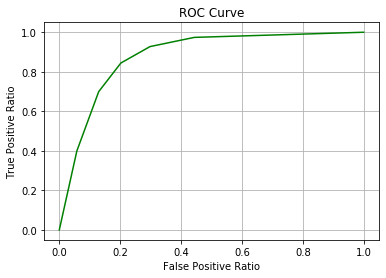

In [33]:
# print(knn_clf.predict_proba(X_test))

y_pred_prob = knn_clf.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.plot(fpr, tpr, color='green')
plt.xlabel("False Positive Ratio")
plt.ylabel("True Positive Ratio")
plt.title("ROC Curve")
plt.grid()

print("The probability of getting a TP over a FP as per AUC is: %0.2f" % (roc_auc_score(y_test, y_pred_prob)))